In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

from aux_fun import *
import time
start = time.time()

In [2]:
car_image_fnames = glob.glob('data/vehicles/KITTI_extracted/*.png')
not_car_image_fnames = glob.glob('data/non-vehicles/Extras/*.png')

In [3]:
PARAMS = {
    'use_hog': True,
    'hog_cspace': 'LUV',
    'channels_for_hog': [0],
    'hog_orientations': 9,
    'hog_pixels_per_cell': 8,
    'hog_cells_per_block': 2,
    'use_spatial': True,
    'spatial_cspace': 'RGB',
    'use_hist': True,
    'hist_cspace': 'RGB',
    'hist_nbins': 32,
    'spatial_resize': 20
}

In [4]:
def extract_single_img_features(img_rgb, 
                                use_hog, hog_cspace, channels_for_hog,
                                hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                use_hist, hist_cspace, hist_nbins,
                                use_spatial, spatial_cspace, spatial_resize
                               ):
    
    img_spatial = np.copy(img_rgb) if spatial_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % spatial_cspace)
    img_hist = np.copy(img_rgb) if hist_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % hist_cspace)
    img_hog = np.copy(img_rgb) if hog_cspace=='RGB' else convert_color(img_rgb, 'RGB2%s' % hog_cspace)
    
    spatial_features = extract_spatial_features(img_spatial, size=(spatial_resize,)*2)
    hist_features = extract_hist_features(img_hist, nbins=hist_nbins)
    hog_features_list = list()
    for ch in channels_for_hog:
        hog_features_list.append(
            extract_hog_features(img_hog[:,:,ch], hog_orientations, hog_pixels_per_cell, hog_cells_per_block)
        )
    hog_features = np.concatenate(hog_features_list)
    
    features_list = list()
    if use_spatial:
        features_list.append(spatial_features)
    if use_hist:
        features_list.append(hist_features)
    if use_hog:
        features_list.append(hog_features)
    
    return np.concatenate(features_list)

In [5]:
def extract_features_from_img_file_list(img_fname_list,
                                        use_hog, hog_cspace, channels_for_hog,
                                        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                        use_hist, hist_cspace, hist_nbins,
                                        use_spatial, spatial_cspace, spatial_resize
                                       ):
    feature_list = list()
    for img_fname in img_fname_list:
        img_features = list()
        img_rgb = io.imread(img_fname)
        feature_list.append(
            extract_single_img_features(img_rgb, 
                                        use_hog, hog_cspace, channels_for_hog,
                                        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                                        use_hist, hist_cspace, hist_nbins,
                                        use_spatial, spatial_cspace, spatial_resize
                                       )
        )
    return np.vstack(feature_list)

In [6]:
from sklearn.utils import shuffle
def build_dataset(positive_fname_list, negative_fname_list, 
                    use_hog, hog_cspace, channels_for_hog,
                    hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
                    use_hist, hist_cspace, hist_nbins,
                    use_spatial, spatial_cspace, spatial_resize                 
                 ):
    
    extract = lambda x: extract_features_from_img_file_list(
        x, 
        use_hog, hog_cspace, channels_for_hog,
        hog_orientations, hog_pixels_per_cell, hog_cells_per_block,
        use_hist, hist_cspace, hist_nbins,
        use_spatial, spatial_cspace, spatial_resize   
    )          
    
    X_0 = extract(negative_fname_list)
    y_0 = np.zeros(X_0.shape[0])
    X_1 = extract(positive_fname_list)
    y_1 = np.ones(X_1.shape[0])
    return shuffle(np.vstack([X_0, X_1]), np.concatenate([y_0, y_1]))

In [7]:
X, y = build_dataset(car_image_fnames, not_car_image_fnames, 
                        hog_orientations=PARAMS['hog_orientations'], 
                        hog_pixels_per_cell=PARAMS['hog_pixels_per_cell'], 
                        hog_cells_per_block=PARAMS['hog_cells_per_block'],
                        hist_nbins=PARAMS['hist_nbins'],
                        spatial_resize=PARAMS['spatial_resize'],
                        channels_for_hog=PARAMS['channels_for_hog'],
                        use_hog=PARAMS['use_hog'],
                        hog_cspace=PARAMS['hog_cspace'],
                        use_spatial=PARAMS['use_spatial'],
                        spatial_cspace=PARAMS['spatial_cspace'],
                        use_hist=PARAMS['use_hist'],
                        hist_cspace=PARAMS['hist_cspace']
                    )
print('Dataset size: ', X.shape)

Dataset size:  (11034, 3060)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
from xgboost import XGBClassifier
clf = XGBClassifier(
    max_depth=4, 
    n_estimators=100, 
    learning_rate=0.1,
    subsample=0.5
)

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
sc_clf = make_pipeline(
    StandardScaler(),
    clf
)

In [11]:
from sklearn.model_selection import cross_val_score
score_list = cross_val_score(sc_clf, X_train, y_train, scoring='accuracy')
print('CV accuracy: %0.3f +- %0.3f' % (np.mean(score_list), 2*np.std(score_list)))

CV accuracy: 0.997 +- 0.001


In [12]:
sc_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbclassifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5))])

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('Test score - roc_auc: %0.3f' % roc_auc_score(y_test, sc_clf.predict_proba(X_test)[:,1]))
print('Test score - accuracy: %0.3f' % accuracy_score(y_test, sc_clf.predict(X_test)))

Test score - roc_auc: 1.000
Test score - accuracy: 0.997


In [14]:
sc_clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbclassifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5))])

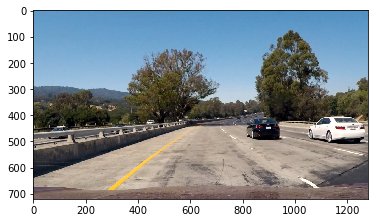

In [15]:
test_img = io.imread('test_images/test1.jpg')
plt.imshow(test_img);

In [16]:
def find_cars(img, ystart, ystop, scale, clf_pl, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, 
              hist_bins,
              use_hog=True,
              hog_cspace='LUV',
              use_spatial=True,
              spatial_cspace='RGB',
              use_hist=True,
              hist_cspace='RGB',
              channels_for_hog=[0,1,2]
             ):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Color space transformation for each feature extraction method
    ctrans_tosearch_hog = np.copy(img_tosearch) if hog_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % hog_cspace)
    ctrans_tosearch_spatial = np.copy(img_tosearch) if spatial_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % spatial_cspace)
    ctrans_tosearch_hist = np.copy(img_tosearch) if hist_cspace=='RGB' else convert_color(img_tosearch, 'RGB2%s' % hist_cspace)
    
    # Compute individual channel HOG features for the entire image
    hog_features_per_channel = list()
    for i in channels_for_hog:
        hog_i = extract_hog_features(
            ctrans_tosearch_hog[:,:,i], 
            orient, pix_per_cell, cell_per_block, feature_vector=False
        )
        hog_features_per_channel.append(hog_i)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_subsampled_features_list = list()
            for hog_ch_feats in hog_features_per_channel:
                hog_ch_feats_subsample = hog_ch_feats[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_subsampled_features_list.append(hog_ch_feats_subsample)
            hog_features = np.concatenate(hog_subsampled_features_list)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg_spatial = cv2.resize(ctrans_tosearch_spatial[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg_hist = cv2.resize(ctrans_tosearch_hist[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = extract_spatial_features(subimg_spatial, size=(spatial_size,)*2)
            hist_features = extract_hist_features(subimg_hist, nbins=hist_bins)

            # Scale features and make a prediction
            feature_list = list()
            if use_spatial:
                feature_list.append(spatial_features)
            if use_hist:
                feature_list.append(hist_features)
            if use_hog:
                feature_list.append(hog_features)
            test_features = np.concatenate(feature_list)[np.newaxis]  
            test_prediction = clf_pl.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

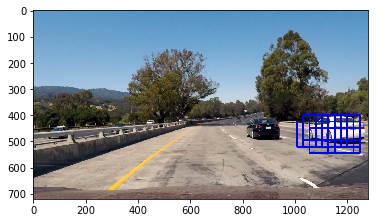

In [17]:
test_output = find_cars(
    test_img, 
    ystart=400, ystop=656, 
    scale=1.5, 
    clf_pl=sc_clf, 
    use_hog=PARAMS['use_hog'], hog_cspace=PARAMS['hog_cspace'], 
    channels_for_hog=PARAMS['channels_for_hog'],
    orient=PARAMS['hog_orientations'], 
    pix_per_cell=PARAMS['hog_pixels_per_cell'], 
    cell_per_block=PARAMS['hog_cells_per_block'],
    use_spatial=PARAMS['use_spatial'], spatial_cspace=PARAMS['spatial_cspace'], 
    spatial_size=PARAMS['spatial_resize'], 
    use_hist=PARAMS['use_hist'], hist_cspace=PARAMS['hist_cspace'], 
    hist_bins=PARAMS['hist_nbins']
)

plt.imshow(test_output);

In [18]:
print('Execution time: %0.1f s' % (time.time() - start))

Execution time: 102.1 s
